# Heat Transfer II

February 26th, 2025

Data analysis & Comsol post-processing by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats, odr
from IPython.display import display, HTML
from numpy.polynomial import Polynomial
import warnings
warnings.filterwarnings('ignore')

In [2]:
k = 120 #Thermal conductivity of brass in W/mK

data = {
    'Flow Rate (SCFM)': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    'Thermistor #': [4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6],
    'Temperature 1 (°C)': [115.8, 113.6, 111.7, 113.3, 110.8, 108.4, 112.0, 109.1, 106.3, 109.0, 106.8, 104.1],
    'Temperature 2 (°C)': [116.2, 114.8, 112.7, 116.0, 113.9, 111.1, 115.7, 113.2, 110.1, 115.1, 112.0, 108.5],
    'Temperature 3 (°C)': [None, None, None, 115.8, 113.4, 111.0, 114.7, 111.8, 108.7, None, None, None],
}

df = pd.DataFrame(data)
df['Avg Temp (°C)'] = df[['Temperature 1 (°C)', 'Temperature 2 (°C)', 'Temperature 3 (°C)']].mean(axis=1)

Avg_Power = np.array([35.495, 42.33333333, 44.83333333, 45.13333333])
distances = np.array([0.0177, 0.0431, 0.0685]) #Distances through brass rod (m)
set_temp = 133 #Thermocouple temp (°C)
df

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Avg Temp (°C)
0,1,4,115.8,116.2,NaN,116.000000
1,1,5,113.6,114.8,NaN,114.200000
2,1,6,111.7,112.7,NaN,112.200000
3,2,4,113.3,116.0,115.8,115.033333
4,2,5,110.8,113.9,113.4,112.700000
5,2,6,108.4,111.1,111.0,110.166667
6,3,4,112.0,115.7,114.7,114.133333
7,3,5,109.1,113.2,111.8,111.366667
8,3,6,106.3,110.1,108.7,108.366667
9,4,4,109.0,115.1,NaN,112.050000


## Question 2

From an appropriate plot of your thermistor data, obtain the convective heat-transfer
coefficient at the end of the rod, h, for all air flow rates. Fit your data utilizing the method
you determine most appropriate to extrapolate the temperature and its gradient at the
brass-rod face.

$$q_s = h\Delta T$$

$$q = -k\nabla T$$

$$h = \frac{-k_{brass}(\frac{dT}{dx})}{T_{surface}-T_{air}}$$

<Figure size 800x600 with 0 Axes>

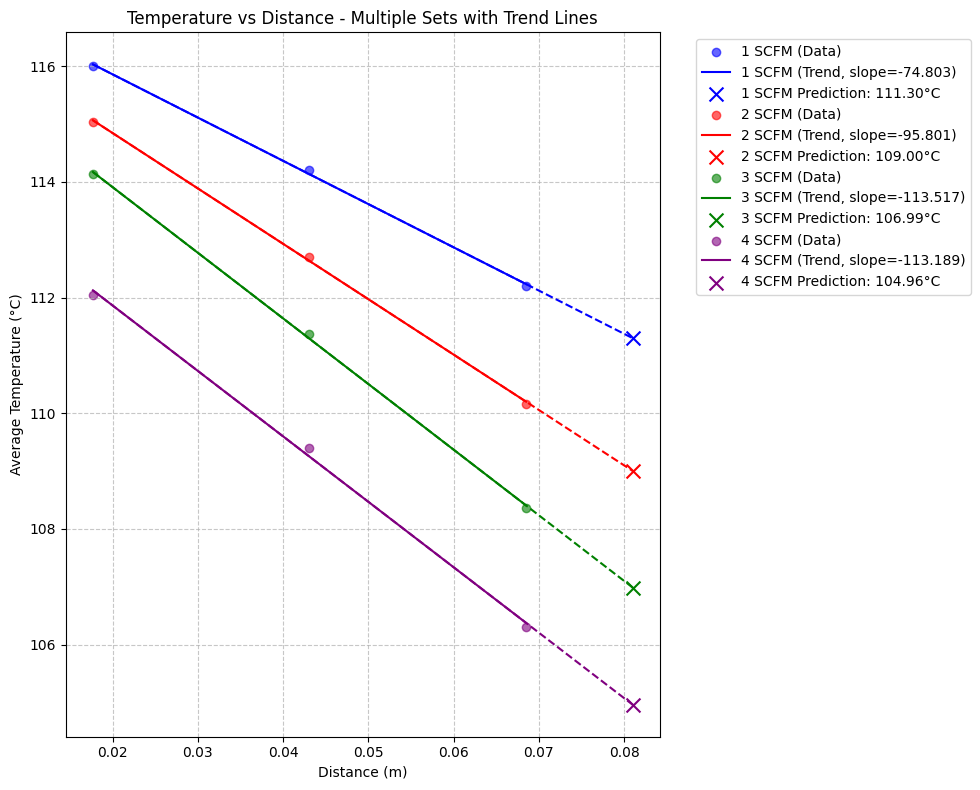

[-74.80314960629914, -95.80052493438333, -113.51706036745402, -113.18897637795274]


In [3]:
plt.figure(figsize=(8, 6))

avg_temps1SCFM = df['Avg Temp (°C)'][0:3]
avg_temps2SCFM = df['Avg Temp (°C)'][3:6]
avg_temps3SCFM = df['Avg Temp (°C)'][6:9]
avg_temps4SCFM = df['Avg Temp (°C)'][9:]
avg_temps = [avg_temps1SCFM, avg_temps2SCFM, avg_temps3SCFM, avg_temps4SCFM]

target_distance = 0.081
predictions = np.zeros(len(avg_temps))

colors = ['blue', 'red', 'green', 'purple']
labels = ['1 SCFM', '2 SCFM', '3 SCFM', '4 SCFM']

dT_dz = []
plt.figure(figsize=(10, 8))

for i, temps in enumerate(avg_temps):
    plt.scatter(distances, temps, color=colors[i], alpha=0.6, label=f'{labels[i]} (Data)')

    slope, intercept, r_value, p_value, std_err = stats.linregress(distances, temps)
    dT_dz.append(slope)
    line = slope * np.array(distances) + intercept
    plt.plot(distances, line, color=colors[i], linestyle='-', 
             label=f'{labels[i]} (Trend, slope={slope:.3f})')
    predictions[i] = slope * target_distance + intercept

    x_extended = np.append([target_distance], distances)
    x_extended.sort()  # Sort to ensure proper line plotting
    
    # Plot extended trend line
    line_extended = slope * x_extended + intercept
    plt.plot(x_extended, line_extended, color=colors[i], linestyle='--')
    plt.scatter(target_distance, predictions[i], color=colors[i], marker='x', s=100,
               label=f'{labels[i]} Prediction: {predictions[i]:.2f}°C')

plt.xlabel('Distance (m)')
plt.ylabel('Average Temperature (°C)')
plt.title('Temperature vs Distance - Multiple Sets with Trend Lines')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

dT_dz = [float(slope) for slope in dT_dz]
print(dT_dz)

### Calculation of h

$$h = \frac{-k_{brass}(\frac{dT}{dx})}{T_{surface}-T_{air}}$$
where $k_{brass}$ is the thermal conductivity of brass, $\frac{dT}{dz}$ is the temperature gradient, $h$ is the convective heat transfer coefficient $[W/m^2/K]$, and $\Delta T$ is the temperature difference $[K]$ between the surface and bulk fluid $(T_s-T_e)$.

In [4]:
T_s = predictions
T_e = 20.6 # C
A_cross = np.pi * (0.025 / 2) **2
h = [-k * dT_dz[i] / (T_s[i] - T_e) for i in range(len(T_s))]

print('Heat transfer coefficients are:', h) 

Heat transfer coefficients are: [np.float64(98.96964496810249), np.float64(130.042293435388), np.float64(157.68705398907983), np.float64(161.00823825485736)]


### Values we have calculated so far

In [5]:
calc_data = {
    'Flow Rate (SCFM)': [1, 2, 3, 4],
    'Air Velocity (m/s)': [0.5942230889,1.188446178,1.782669267,2.376892355],
    'T_surface (°C)': T_s,
    '(T_surface - T_air) (°C)': T_s - T_e,
    'dT/dx (°C/m)': dT_dz,
    'h (W/m²K)': h,
}
calc_vals_df = pd.DataFrame(calc_data)
calc_vals_df

,Flow Rate (SCFM),Air Velocity (m/s),T_surface (°C),(T_surface - T_air) (°C),dT/dx (°C/m),h (W/m²K)
0,1,0.594223,111.298294,90.698294,-74.803150,98.969645
1,2,1.188446,109.002493,88.402493,-95.800525,130.042293
2,3,1.782669,106.986592,86.386592,-113.517060,157.687054
3,4,2.376892,104.960138,84.360138,-113.188976,161.008238


In [6]:
df_values = pd.merge(df, calc_vals_df[['Flow Rate (SCFM)', 'h (W/m²K)']], on='Flow Rate (SCFM)', how='left')

df_values

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Avg Temp (°C),h (W/m²K)
0,1,4,115.8,116.2,NaN,116.000000,98.969645
1,1,5,113.6,114.8,NaN,114.200000,98.969645
2,1,6,111.7,112.7,NaN,112.200000,98.969645
3,2,4,113.3,116.0,115.8,115.033333,130.042293
4,2,5,110.8,113.9,113.4,112.700000,130.042293
5,2,6,108.4,111.1,111.0,110.166667,130.042293
6,3,4,112.0,115.7,114.7,114.133333,157.687054
7,3,5,109.1,113.2,111.8,111.366667,157.687054
8,3,6,106.3,110.1,108.7,108.366667,157.687054
9,4,4,109.0,115.1,NaN,112.050000,161.008238


## Question 3
Calculate the axial heat flux leaving the brass-rod face. Estimate the overall radial heat-
transfer coefficient, U, between the brass rod and the surrounding air. You must consider
what heat-transfer resistances exist between the rod and the air. How does the magnitude
of your estimated U compare to the values of heater power input and h measured at the
rod face? What can you say about the energy balance of this system? Identify the sources
of heat loss. When estimating the axial heat flux, what is the most appropriate value for
the length of the cylinder (should you include or exclude the section with the heater)?

### Calculating Axial Heat Flux
Use Fourier's Law:
$$q_{axial} = -k(\frac{dT}{dz})$$
where $k$ = thermal conductivity of brass, $\frac{dT}{dx}$= temperature gradient

In [7]:
k_brass = 120 #W/m·K (thermal conductivity of brass)
rod_diameter = 0.025  #meters, m
rod_length = 0.081 #meters, m
T_e = 20.6 # C
A_cross
surface_area = 2*np.pi * (rod_diameter/2 )* rod_length + 2*np.pi* (rod_diameter/2)**2 # m^2
num_flows = len(predictions)
nozzle_diam = 0.0318 # m

axial_heat_flux = np.zeros(num_flows)
Q_axial = np.zeros(num_flows)

for i in range(num_flows):
    axial_heat_flux[i] = -k_brass * dT_dz[i]
    Q_axial[i] = axial_heat_flux[i] * A_cross

print("\nAxial Heat Flux Results:")
for i in range(len(axial_heat_flux)):
    print(f"{labels[i]}:")
    print(f"Heat Flux: {axial_heat_flux[i]:.2f} W/m²")
    print(f"Total Axial Heat Transfer: {Q_axial[i]:.2f} W")


Axial Heat Flux Results:
1 SCFM:
Heat Flux: 8976.38 W/m²
Total Axial Heat Transfer: 4.41 W
2 SCFM:
Heat Flux: 11496.06 W/m²
Total Axial Heat Transfer: 5.64 W
3 SCFM:
Heat Flux: 13622.05 W/m²
Total Axial Heat Transfer: 6.69 W
4 SCFM:
Heat Flux: 13582.68 W/m²
Total Axial Heat Transfer: 6.67 W


### Estimating Overal Radial Heat-Transfer Coefficient, U 

Sources of Heat Loss:
* Radial heat loss through the insulation
* End losses at the brass-rod face
* Assuming no heat loss other than axial or radial

Resistances to heat transfer from rod to air:
* High conductivity means low resistance for conduction through brass
* Convection from surface to air is main source of resistance

Overall energy balance equation:
$$Q_{in}=Q_{axial} + Q_{radial} + Q_{losses}$$

Assuming no heat loss, we can cancel Q_losses
$$Q_{in}=Q_{axial} + Q_{radial}$$
$$Q_{radial}=Q_{in} - Q_{axial} $$

$$U_{radial} = \frac {Q_{in}- Q_{axial}} {SA(T_{surf} - T_{air})} $$


In [8]:
Q_in = Avg_Power
U =  (Q_in - Q_axial) / (surface_area*(T_s - T_e))
print('The overall radial heat transfer coefficient at each flow rate is:', U)

The overall radial heat transfer coefficient at each flow rate is: [46.67694047 56.51767253 60.13236743 62.0922955 ]


The estimated U values are larger than the heater power input and larger than the h measured at the rod face. But the magnitudes are similar between U and h values. When estimating axial heat flux, you should exclude the section with the heater.

### Calculated values table

In [9]:
calc_vals_df = pd.DataFrame(calc_data)
calc_vals_df['U (W/m² K)'] = U
calc_vals_df['Axial Heat Flux (W/m²)'] = axial_heat_flux
calc_vals_df

,Flow Rate (SCFM),Air Velocity (m/s),T_surface (°C),(T_surface - T_air) (°C),dT/dx (°C/m),h (W/m²K),U (W/m² K),Axial Heat Flux (W/m²)
0,1,0.594223,111.298294,90.698294,-74.803150,98.969645,46.676940,8976.377953
1,2,1.188446,109.002493,88.402493,-95.800525,130.042293,56.517673,11496.062992
2,3,1.782669,106.986592,86.386592,-113.517060,157.687054,60.132367,13622.047244
3,4,2.376892,104.960138,84.360138,-113.188976,161.008238,62.092296,13582.677165


## Question 4
Compare the values of the heat-transfer coefficient to values from texts, handbooks, or
references of appropriate heat-transfer correlations. Use (at least) one correlation to
predict the heat transfer coefficient under the experimental conditions (i.e. dimensionless
quantities). Are the geometry and flow conditions in the experiment within the ranges
specified for the chosen correlation? If not, what effect do you expect this to have on the
agreement between experiment and correlation?

Compared to the heat-transfer coefficients from "Experimental study and theoretical analysis of local heat transfer distribution between smooth flat surface and impinging air jet from a circular straight pipe nozzle," our calculated heat-transfer coefficients are of consistent magnitude. The values range from 80 to 170 $[\frac{W}{m^2 K}]$.

### Calculating the heat transfer coefficient using dimensionless quantities
#### Local Reynolds Number ####
$$Re_{r}=\frac{\rho u r}{\mu} = \frac{u r}{\nu}$$
where $\rho$ = density of air, $u$ = fluid velocity, $\mu$ = dynamic fluid viscosity, $\nu$ = kinematic fluid viscosity

#### Prandtl Number
$$Pr = \frac{\nu}{\alpha} = \frac{\mu c_{p}}{k}$$
where $\nu$ = kinematic fluid viscosity, $\alpha$ = thermal diffusivity

#### Nusselt Number
$$Nu = \frac{hL}{k}$$

#### Stanton Number 
$$St = \frac{h}{\rho \nu c_{p}} = \frac{Nu}{RePr}$$

In [20]:
def Reynolds(velocity, diam, kinematic_viscosity):
    return velocity * diam / kinematic_viscosity

air_velocity = calc_vals_df['Air Velocity (m/s)']
radial_length = 0.0125 #m
kin_viscosity_air = 1.51 * 10**-5 #m^2/s
Reynolds_vals = Reynolds(air_velocity, nozzle_diam, kin_viscosity_air)
Reynolds_vals

def Prandtl(momentum_diffusivity, thermal_diffusivity):
    return momentum_diffusivity / thermal_diffusivity

rho_air = 1.203 # kg/m^3
c_p = 1005 # J/kg·K
k_air = 0.025 #W/m*K
alpha = k_air / (rho_air*c_p)

Prandtl_val = Prandtl(kin_viscosity_air, alpha)

def Nus_correl(Re,Pr):
    return 1.54 * Re**(1/2) * Pr**(1/3)

Nu_L = Nus_correl(Reynolds_vals, Prandtl_val)
Nu_L

h = Nu_L * k_air / radial_length
h


0     98.116061
1    138.757065
2    169.942004
3    196.232123
Name: Air Velocity (m/s), dtype: float64

In [11]:
# df_values = pd.merge(df, calc_vals_df[['Flow Rate (SCFM)', 'h (W/m²K)']], on='Flow Rate (SCFM)', how='left') # all raw data + h values
# df_values

air_velocity = calc_vals_df['Air Velocity (m/s)']
radial_length = 0.0125 #m
kin_viscosity_air = 1.51 * 10**-5 #m^2/s
Reynolds_vals = Reynolds(air_velocity, radial_length, kin_viscosity_air)

def Reynolds(velocity, length, kinematic_viscosity):
    return velocity * length / kinematic_viscosity

def Prandtl(momentum_diffusivity, thermal_diffusivity):
    return momentum_diffusivity / thermal_diffusivity

def Nus_correl(Re, Pr):
    return 1.54 * Re**(1/2) * Pr**(1/3) #brdlik and savin prelab question question 3 or in additional resources textbook references

results = []
prandtl_number = Prandtl(kin_viscosity_air, alpha)

for flow_rate, velocity in zip(df["Flow Rate (SCFM)"], calc_vals_df['Air Velocity (m/s)']):
    reynolds_number = Reynolds(velocity, radial_length, kin_viscosity_air)
    nusselt_number = Nus_correl(reynolds_number, prandtl_number)
    heat_transfer_coeff = nusselt_number * k_air / radial_length
    
    results.append({
        'Flow Rate (SCFM)': flow_rate,
        'Air Velocity (m/s)': velocity,
        'Reynolds Number': reynolds_number,
        'Prandtl Number': prandtl_number,
        'Nusselt Number': nusselt_number,
        'Heat Transfer Coefficient (W/m²·K)': heat_transfer_coeff
    })

dimensionless_df = pd.DataFrame(results)

## Question 5
Determine the scaling of the experimental heat-transfer coefficient with jet velocity or,
equivalently, the scaling of the Nusselt number with the Reynolds number. Plot the data
in a way that the scaling exponent can be determined graphically. How does the scaling
exponent obtained experimentally compare to that predicted by the correlations?


In [12]:
calc_vals_df

,Flow Rate (SCFM),Air Velocity (m/s),T_surface (°C),(T_surface - T_air) (°C),dT/dx (°C/m),h (W/m²K),U (W/m² K),Axial Heat Flux (W/m²)
0,1,0.594223,111.298294,90.698294,-74.803150,98.969645,46.676940,8976.377953
1,2,1.188446,109.002493,88.402493,-95.800525,130.042293,56.517673,11496.062992
2,3,1.782669,106.986592,86.386592,-113.517060,157.687054,60.132367,13622.047244
3,4,2.376892,104.960138,84.360138,-113.188976,161.008238,62.092296,13582.677165


Slope: 0.3707
Standard Error of Slope: 0.0422
Y-intercept: 2.0844
R-squared: 0.9747
P-value: 0.0127
Standard Deviation of Residuals: 0.0135


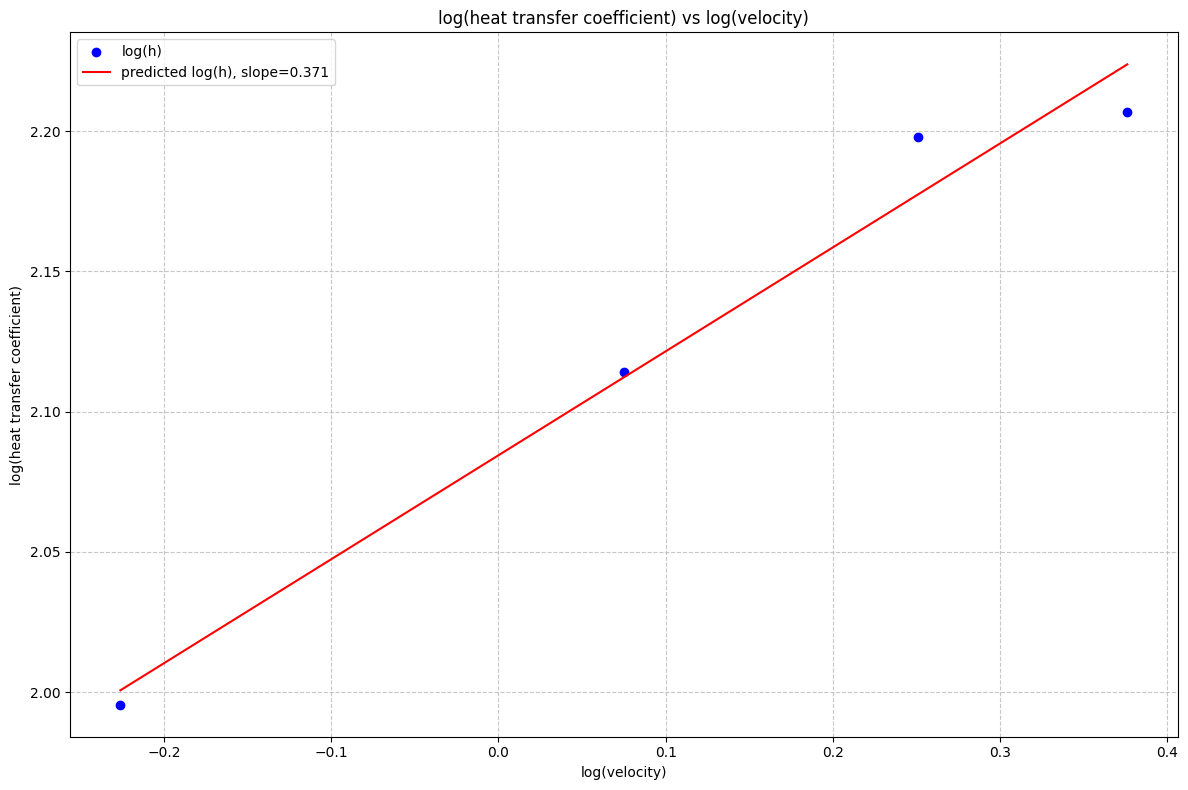

In [13]:
calc_vals_df['log(h)'] = np.log10(calc_vals_df['h (W/m²K)'])
calc_vals_df['log(u)'] = np.log10(calc_vals_df['Air Velocity (m/s)'])
calc_vals_df

slope, intercept, r_value, p_value, std_err = stats.linregress(calc_vals_df['log(u)'], calc_vals_df['log(h)'])
line = slope * calc_vals_df['log(u)'] + intercept

plt.figure(figsize=(12, 8))
plt.scatter(calc_vals_df['log(u)'], calc_vals_df['log(h)'], color='blue', label='log(h)')
plt.plot(calc_vals_df['log(u)'], line, color='red', label=f'predicted log(h), slope={slope:.3f}')

plt.title('log(heat transfer coefficient) vs log(velocity)')
plt.xlabel('log(velocity)')
plt.ylabel('log(heat transfer coefficient)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

print(f"Slope: {slope:.4f}")
print(f"Standard Error of Slope: {std_err:.4f}")
print(f"Y-intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

residuals = calc_vals_df['log(h)'] - line
std_dev = np.std(residuals)
print(f"Standard Deviation of Residuals: {std_dev:.4f}")

plt.tight_layout()
plt.show()

#### Scaling of the experimental heat transfer coefficient with jet velocity
$$h \ \alpha \ u^{0.3707±0.0422}$$
#### The scaling exponent predicted by correlations is 
$$ Nu \ \alpha \ Re ^ {0.5} $$

#### Let's plot this as well to see how the relationship compares

In [14]:
dimensionless_df["experimental Nusselt Number"] = (dimensionless_df["Heat Transfer Coefficient (W/m²·K)"] *(rod_diameter / 2)) / k

dimensionless_df["log Reynolds Number"] = np.log10(dimensionless_df["Reynolds Number"])
dimensionless_df["log Nusselt Number"] = np.log10(dimensionless_df["Nusselt Number"])
dimensionless_df["log experimental Nusselt Number"] = np.log10(dimensionless_df["experimental Nusselt Number"])
dimensionless_df

,Flow Rate (SCFM),Air Velocity (m/s),Reynolds Number,Prandtl Number,Nusselt Number,Heat Transfer Coefficient (W/m²·K),experimental Nusselt Number,log Reynolds Number,log Nusselt Number,log experimental Nusselt Number
0,1,0.594223,491.906531,0.730245,30.757537,61.515074,0.006408,2.691883,1.487952,-2.193290
1,1,1.188446,983.813061,0.730245,43.497726,86.995452,0.009062,2.992913,1.638467,-2.042775
2,1,1.782669,1475.719592,0.730245,53.273617,106.547234,0.011099,3.169004,1.726512,-1.954729
3,2,2.376892,1967.626122,0.730245,61.515074,123.030149,0.012816,3.293943,1.788982,-1.892260


Slope: 0.5000
Standard Error of Slope: 0.0000
Y-intercept: -3.5392
R-squared: 1.0000
P-value: 0.0000
Standard Deviation of Residuals: 0.0322


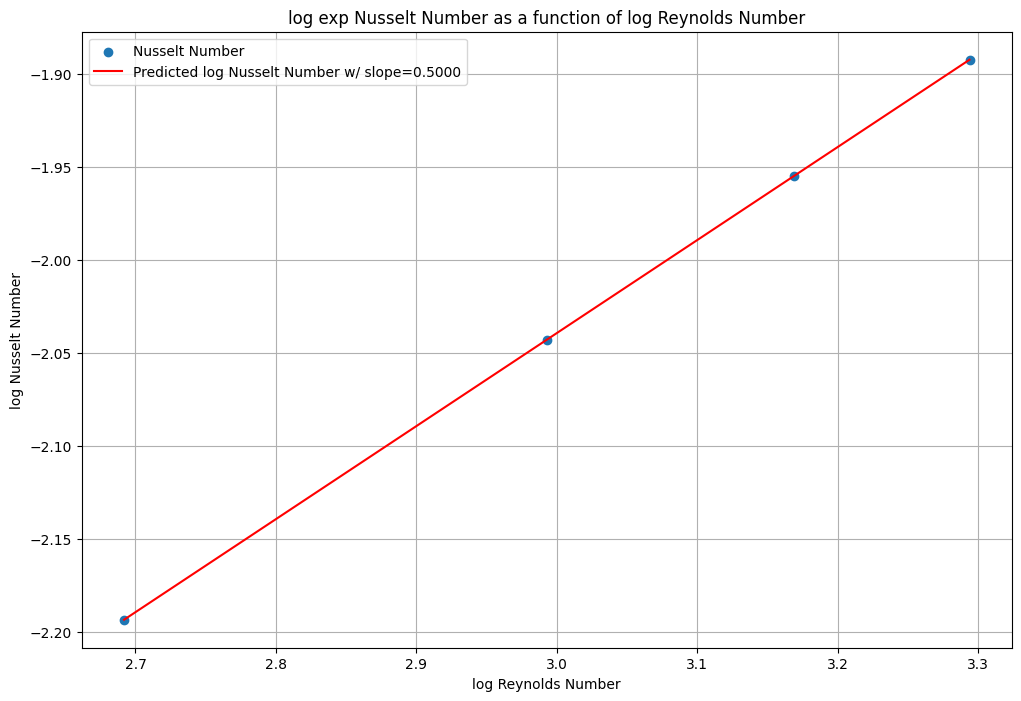

In [15]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dimensionless_df["log Reynolds Number"], dimensionless_df['log experimental Nusselt Number'])
line = slope * dimensionless_df["log Reynolds Number"] + intercept
plt.figure(figsize=(12, 8))
plt.scatter(dimensionless_df["log Reynolds Number"], dimensionless_df["log experimental Nusselt Number"], label = "Nusselt Number")
plt.plot(dimensionless_df["log Reynolds Number"], line, label=f"Predicted log Nusselt Number w/ slope={slope:.4f}", color = "red")
plt.title("log exp Nusselt Number as a function of log Reynolds Number")
plt.xlabel("log Reynolds Number")
plt.ylabel("log Nusselt Number")
plt.grid()
plt.legend()

print(f"Slope: {slope:.4f}")
print(f"Standard Error of Slope: {std_err:.4f}")
print(f"Y-intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

residuals = calc_vals_df['log(h)'] - line
std_dev = np.std(residuals)
print(f"Standard Deviation of Residuals: {std_dev:.4f}")

Thus, we have:

$$ Nu \ \alpha \ Re ^ {0.0207±0.0015} $$
$$h \ \alpha \ u^{0.3707±0.0422}$$

The heat transfer coefficient gives us a relationship closer to the theoretical expression.

# COMSOL Data Analysis & Report Tasks

### Question 3: 
Plot the axial temperatures along the rod along the centerline (i.e., T(0, z>0)) and compare
them to your experimental values

In [16]:
def get_positions(thermistor_number):
    if thermistor_number == 6:
        return 12.5
    elif thermistor_number == 5:
        return 12.5 + 25.4
    elif thermistor_number == 4:
        return 12.5 + 25.4 + 25.4
    else:
        return None
    
df["positions (mm)"] = df["Thermistor #"].apply(get_positions)

In [17]:
df

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Avg Temp (°C),positions (mm)
0,1,4,115.8,116.2,NaN,116.000000,63.3
1,1,5,113.6,114.8,NaN,114.200000,37.9
2,1,6,111.7,112.7,NaN,112.200000,12.5
3,2,4,113.3,116.0,115.8,115.033333,63.3
4,2,5,110.8,113.9,113.4,112.700000,37.9
5,2,6,108.4,111.1,111.0,110.166667,12.5
6,3,4,112.0,115.7,114.7,114.133333,63.3
7,3,5,109.1,113.2,111.8,111.366667,37.9
8,3,6,106.3,110.1,108.7,108.366667,12.5
9,4,4,109.0,115.1,NaN,112.050000,63.3


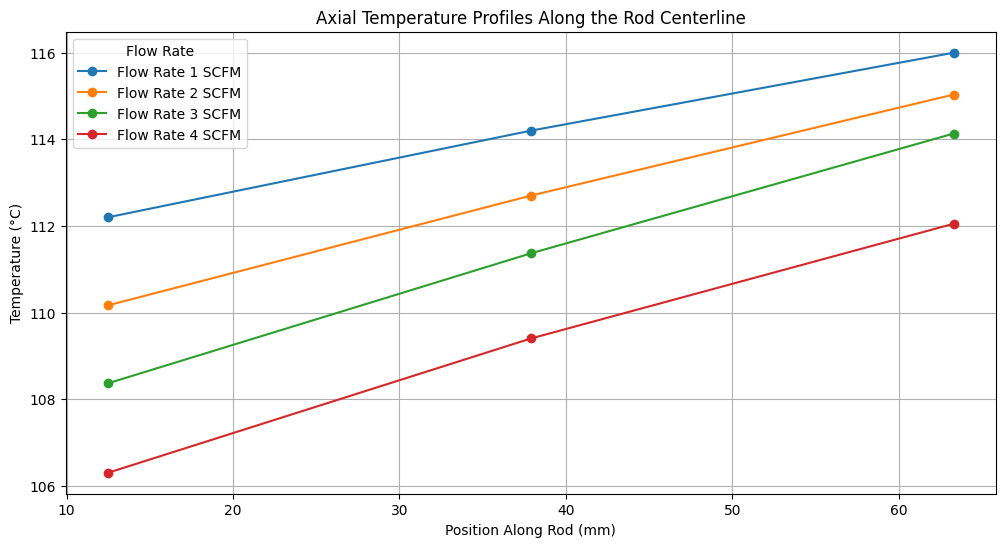

In [18]:
plt.figure(figsize=(12, 6))
flow_rates = df['Flow Rate (SCFM)'].unique()
for flow_rate in flow_rates:
    df_flow = df[df['Flow Rate (SCFM)'] == flow_rate].copy()
    df_flow.sort_values(by=['positions (mm)'], inplace=True)
    
    plt.plot(df_flow['positions (mm)'], df_flow['Avg Temp (°C)'], marker='o', label=f'Flow Rate {flow_rate} SCFM')

plt.title('Axial Temperature Profiles Along the Rod Centerline')
plt.xlabel('Position Along Rod (mm)')
plt.ylabel('Temperature (°C)')
plt.legend(title="Flow Rate")
plt.grid(True)
plt.show()

Reading in COMSOL simulated results to compare our experimental results with simulated results

In [19]:
df_sim_1 = pd.read_csv("data/Heat Transfer Lab COMSOL Data - 1 SCFM Data.csv")
df_sim_2 = pd.read_csv("data/Heat Transfer Lab COMSOL Data - 2 SCFM Data.csv")
df_sim_3 = pd.read_csv("data/Heat Transfer Lab COMSOL Data - 3 SCFM Data.csv")
df_sim_4 = pd.read_csv("data/Heat Transfer Lab COMSOL Data - 4 SCFM Data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/Heat Transfer Lab COMSOL Data - 1 SCFM Data.csv'

In [ ]:
df_sim_1.head()

,r,z,T (K)
0,0.001092,-0.008912,313.091756
1,0.000000,-0.010000,293.600000
2,0.001590,-0.010000,293.600000
3,0.000000,-0.008002,317.777552
4,0.002418,-0.008780,307.997580


Extracting values for z > 0 and r == 0 and sorting by axial position (z)

In [ ]:
center_rod_1 = df_sim_1.query("r == 0 and z > 0")
center_rod_2 = df_sim_2.query("r == 0 and z > 0")
center_rod_3 = df_sim_3.query("r == 0 and z > 0")
center_rod_4 = df_sim_4.query("r == 0 and z > 0")

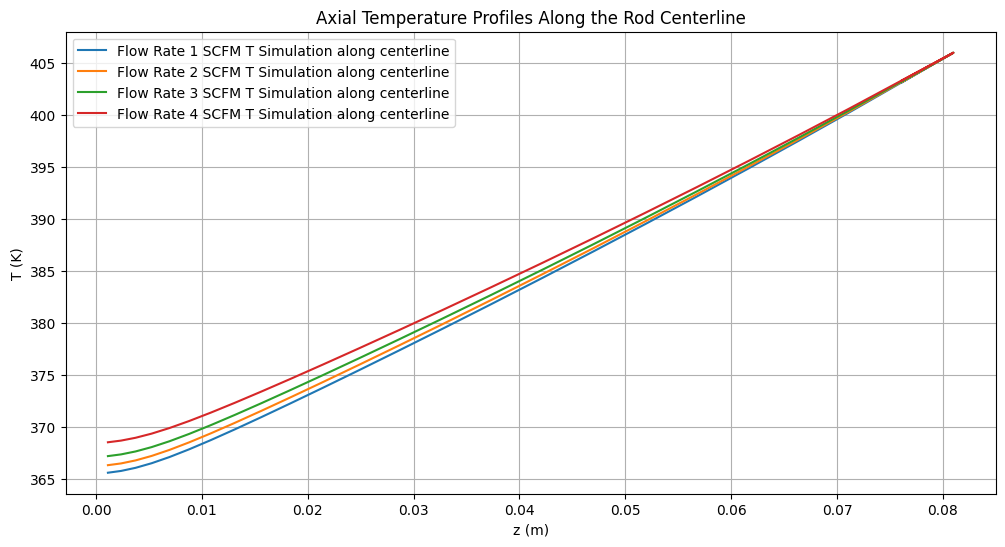

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(center_rod_1['z'], center_rod_1['T (K)'], label = 'Flow Rate 1 SCFM T Simulation along centerline')
plt.plot(center_rod_2['z'], center_rod_2['T (K)'], label = 'Flow Rate 2 SCFM T Simulation along centerline')
plt.plot(center_rod_3['z'], center_rod_3['T (K)'], label = 'Flow Rate 3 SCFM T Simulation along centerline')
plt.plot(center_rod_4['z'], center_rod_4['T (K)'], label = 'Flow Rate 4 SCFM T Simulation along centerline')
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Axial Temperature Profiles Along the Rod Centerline')
plt.grid()
plt.legend()
plt.show()

### Question 4:
Heat transfer between the air and the brass rod takes place through the thermal boundary
layer. The boundary layer is the major source of resistance to heat transfer in the gas phase.
Plot the centerline temperature profile in the air as a function of distance from the brass-rod
face (i.e., T(0, z<0)) at varying Vin.

In [ ]:
BL_1 = df_sim_1.query("r == 0 and z < 0")
BL_2 = df_sim_2.query("r == 0 and z < 0")
BL_3 = df_sim_3.query("r == 0 and z < 0")
BL_4 = df_sim_4.query("r == 0 and z < 0")

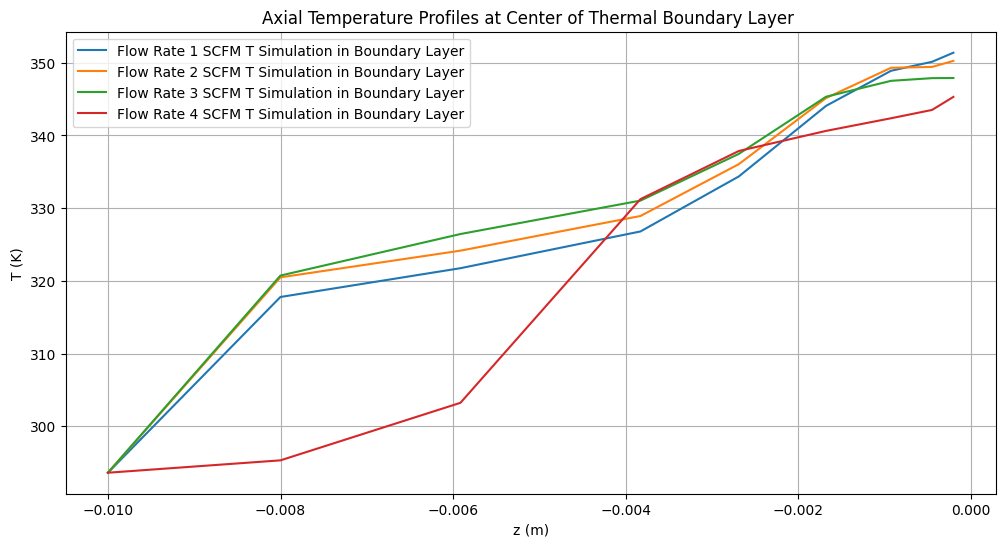

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(BL_1['z'], BL_1['T (K)'], label = 'Flow Rate 1 SCFM T Simulation in Boundary Layer')
plt.plot(BL_2['z'], BL_2['T (K)'], label = 'Flow Rate 2 SCFM T Simulation in Boundary Layer')
plt.plot(BL_3['z'], BL_3['T (K)'], label = 'Flow Rate 3 SCFM T Simulation in Boundary Layer')
plt.plot(BL_4['z'], BL_4['T (K)'], label = 'Flow Rate 4 SCFM T Simulation in Boundary Layer')
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Axial Temperature Profiles at Center of Thermal Boundary Layer ')
plt.grid()
plt.legend()
plt.show()

### Question 5
Compute and plot the heat transfer coefficient h vs. distance r along the rod face for each
value of the inlet velocity

In [ ]:
rod_face_1 = df_sim_1.query("z == 0")
rod_face_2 = df_sim_2.query("z == 0")
rod_face_3 = df_sim_3.query("z == 0")
rod_face_4 = df_sim_4.query("z == 0")

We know that h is a function of dt/dr, so let's first plot temperature vs radius and see what relationship that has so we can understand how to extract dt/dr from it

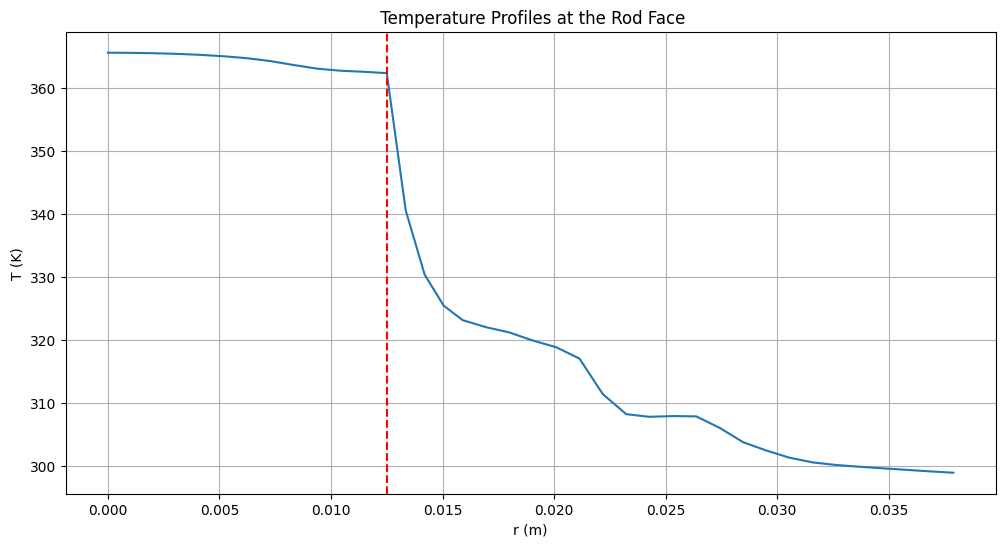

In [ ]:
rod_face_1.sort_values(by='r', inplace=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(rod_face_1['r'], rod_face_1['T (K)'])

plt.figure(figsize=(12, 6))
plt.plot(rod_face_1['r'], rod_face_1['T (K)'])
plt.axvline(x=.0125, color='r', linestyle='--')  
plt.xlabel('r (m)')
plt.ylabel('T (K)')
plt.title(' Temperature Profiles at the Rod Face')
plt.grid()
plt.show()

##### This plot indicates that it is highly non-linear, so what we can try is using a localized first-derivative and plotting against r using that. We also are told the local value of h is defined in terms of the local heat flux at one point along the surface so a local derivative is smart

## Heat Transfer Coefficient Computation using Fourier's Law

Fourier's law for heat conduction is given by:

$$\mathbf{q} = -k \nabla T$$

where:
- q is the heat flux vector (W/m²),
- k is the thermal conductivity of the material (W/m·K),
- grad T is the temperature gradient.

Assuming a **1D conduction model in the radial direction (\( r \)) at \( z = 0 \)**, the gradient operator simplifies to:

$$ q_r = -k \frac{dT}{dr} $$

where:
- q_r is the radial heat flux,
- dT/dr is the temperature gradient in the radial direction.

The convective boundary condition at the rod face relates heat flux to the heat transfer coefficient \( h \):


$$q_r = h (T_{\text{surf}} - T_{e})$$

where:
- T_surf is the surface temperature at \( r \),
- T_e is the ambient air temperature.

Equating conduction and convection at the rod face:

$$h = - k \frac{dT}{dr} \Bigg|_{z=0} \frac{1}{(T_{\text{surf}} - T_{\infty})}$$

Thus, \( h \) can be computed using localized numerical differentiation for dT/dr at z = 0.


In [ ]:
rod_face_1.head()

,r,z,T (K)
137,0.000000,0.0,365.553279
138,0.001042,0.0,365.532961
140,0.002083,0.0,365.472549
142,0.003125,0.0,365.369522
144,0.004167,0.0,365.210594


In [ ]:
df_brass_1 = rod_face_1.query("r <= .0125 and z == 0")
df_nylon_1 = rod_face_1.query("r >= .0125 and z == 0")
df_brass_2 = rod_face_2.query("r <= .0125 and z == 0")
df_nylon_2 = rod_face_2.query("r >= .0125 and z == 0")
df_brass_3 = rod_face_3.query("r <= .0125 and z == 0")
df_nylon_3 = rod_face_3.query("r >= .0125 and z == 0")
df_brass_4 = rod_face_4.query("r <= .0125 and z == 0")
df_nylon_4 = rod_face_4.query("r >= .0125 and z == 0")


df_brass_1.head(5)

,r,z,T (K)
137,0.000000,0.0,365.553279
138,0.001042,0.0,365.532961
140,0.002083,0.0,365.472549
142,0.003125,0.0,365.369522
144,0.004167,0.0,365.210594


In [ ]:
df_brass_1.sort_values(by='r', inplace=True)
df_nylon_1.sort_values(by='r', inplace=True)
df_brass_2.sort_values(by='r', inplace=True)
df_nylon_2.sort_values(by='r', inplace=True)
df_brass_3.sort_values(by='r', inplace=True)
df_nylon_3.sort_values(by='r', inplace=True)
df_brass_4.sort_values(by='r', inplace=True)
df_nylon_4.sort_values(by='r', inplace=True)

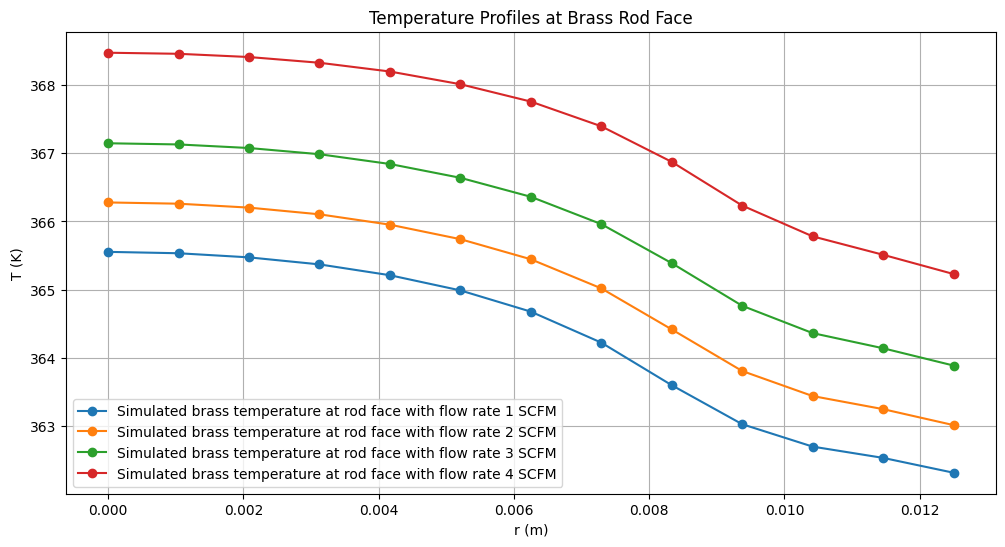

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_brass_1['r'], df_brass_1['T (K)'], marker='o', label = "Simulated brass temperature at rod face with flow rate 1 SCFM")
plt.plot(df_brass_2['r'], df_brass_2['T (K)'], marker='o', label = "Simulated brass temperature at rod face with flow rate 2 SCFM")
plt.plot(df_brass_3['r'], df_brass_3['T (K)'], marker='o', label = "Simulated brass temperature at rod face with flow rate 3 SCFM")
plt.plot(df_brass_4['r'], df_brass_4['T (K)'], marker='o', label = "Simulated brass temperature at rod face with flow rate 4 SCFM")
plt.xlabel('r (m)')
plt.ylabel('T (K)')
plt.legend()
plt.title('Temperature Profiles at Brass Rod Face')
plt.grid()

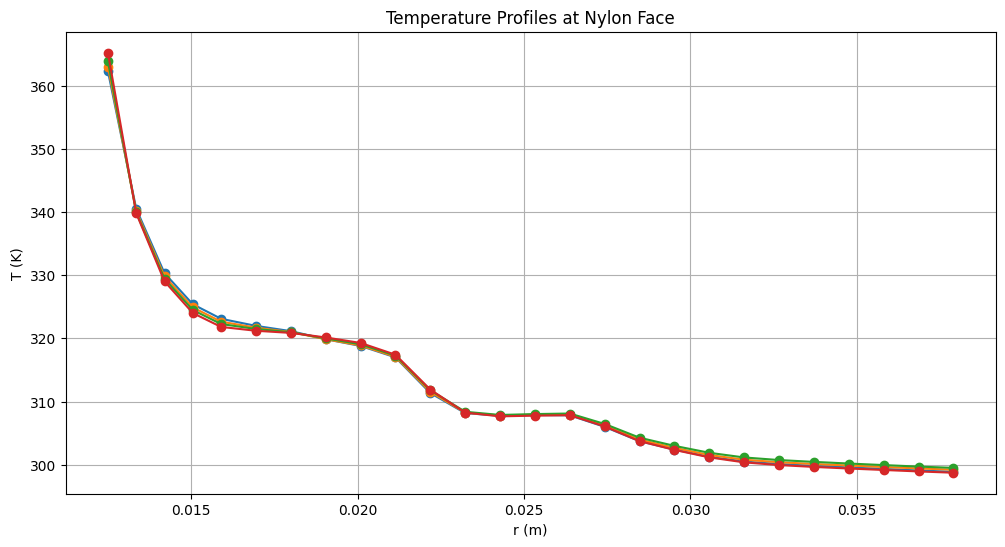

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_nylon_1['r'], df_nylon_1['T (K)'], marker='o', label = "Simulated nylon temperature at rod face with flow rate 1 SCFM")
plt.plot(df_nylon_2['r'], df_nylon_2['T (K)'], marker='o', label = "Simulated nylon temperature at rod face with flow rate 2 SCFM")
plt.plot(df_nylon_3['r'], df_nylon_3['T (K)'], marker='o', label = "Simulated nylon temperature at rod face with flow rate 3 SCFM")
plt.plot(df_nylon_4['r'], df_nylon_4['T (K)'], marker='o', label = "Simulated nylon temperature at rod face with flow rate 4 SCFM")
plt.xlabel('r (m)')
plt.ylabel('T (K)')
plt.title('Temperature Profiles at Nylon Face')
plt.grid()
plt.show()

Now that we have temperature vs radius in the two regimes, we can compute h values for both regimes

In [ ]:
def brass_temp(r, slope, intercept):
    return slope * r + intercept

def linear_model_nylon(r, slope, intercept):
    return slope * r + intercept

def compute_dT_dr(r, T):
    dT_dr = np.gradient(T, r)
    return dT_dr

In [ ]:
k_nylon = 0.25  # W/m·K

In [ ]:
dT_dr_brass_1 = compute_dT_dr(df_brass_1['r'], df_brass_1['T (K)'])
dT_dr_brass_2 = compute_dT_dr(df_brass_2['r'], df_brass_2['T (K)'])
dT_dr_brass_3 = compute_dT_dr(df_brass_3['r'], df_brass_3['T (K)'])
dT_dr_brass_4 = compute_dT_dr(df_brass_4['r'], df_brass_4['T (K)'])

dT_dr_nylon_1 = compute_dT_dr(df_nylon_1['r'], df_nylon_1['T (K)'])
dT_dr_nylon_2 = compute_dT_dr(df_nylon_2['r'], df_nylon_2['T (K)'])
dT_dr_nylon_3 = compute_dT_dr(df_nylon_3['r'], df_nylon_3['T (K)'])
dT_dr_nylon_4 = compute_dT_dr(df_nylon_4['r'], df_nylon_4['T (K)'])

h_brass_1 = -k_brass * dT_dr_brass_1
h_brass_2 = -k_brass * dT_dr_brass_2
h_brass_3 = -k_brass * dT_dr_brass_3
h_brass_4 = -k_brass * dT_dr_brass_4

h_nylon_1 = -k_nylon * dT_dr_nylon_1
h_nylon_2 = -k_nylon * dT_dr_nylon_2
h_nylon_3 = -k_nylon * dT_dr_nylon_3
h_nylon_4 = -k_nylon * dT_dr_nylon_4

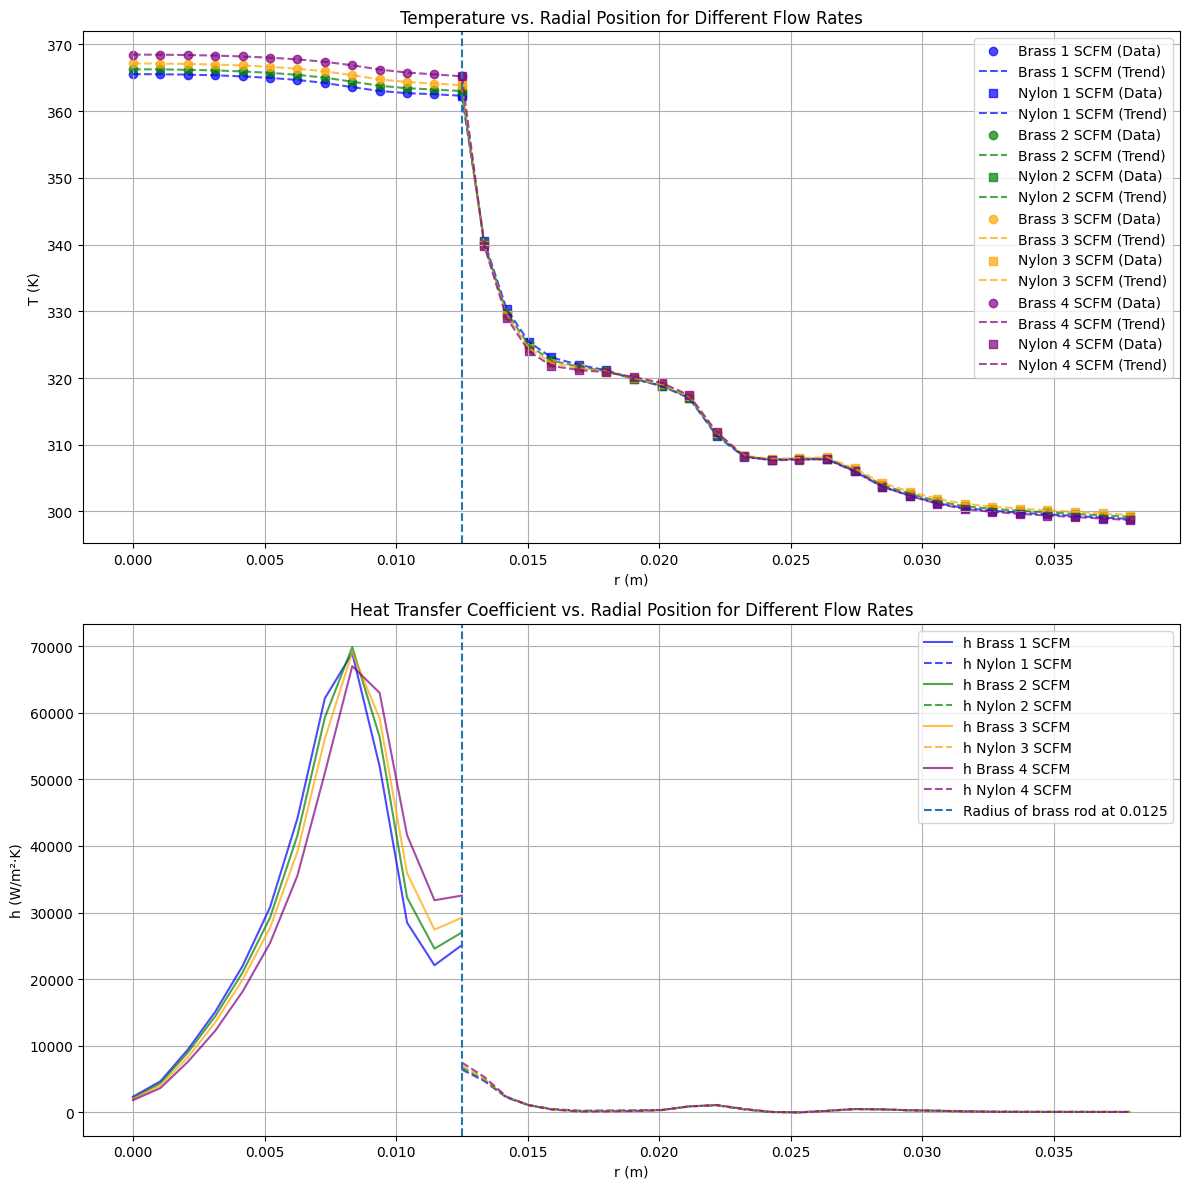

In [ ]:
flow_rates = ["1 SCFM", "2 SCFM", "3 SCFM", "4 SCFM"]
df_brass_list = [df_brass_1, df_brass_2, df_brass_3, df_brass_4]
df_nylon_list = [df_nylon_1, df_nylon_2, df_nylon_3, df_nylon_4]

colors = ["blue", "green", "orange", "purple"]

fig, axs = plt.subplots(2, 1, figsize=(12, 12))

for i, (df_brass, df_nylon) in enumerate(zip(df_brass_list, df_nylon_list)):
    dT_dr_brass = compute_dT_dr(df_brass["r"], df_brass["T (K)"])
    dT_dr_nylon = compute_dT_dr(df_nylon["r"], df_nylon["T (K)"])

    h_brass = -k_brass * dT_dr_brass
    h_nylon = -k_nylon * dT_dr_nylon
    axs[0].scatter(df_brass["r"], df_brass["T (K)"], color=colors[i], alpha=0.7, label=f"Brass {flow_rates[i]} (Data)")
    axs[0].plot(df_brass["r"], df_brass["T (K)"], linestyle="--", color=colors[i], alpha=0.7, label=f"Brass {flow_rates[i]} (Trend)")
    
    axs[0].scatter(df_nylon["r"], df_nylon["T (K)"], color=colors[i], marker='s', alpha=0.7, label=f"Nylon {flow_rates[i]} (Data)")
    axs[0].plot(df_nylon["r"], df_nylon["T (K)"], linestyle="--", color=colors[i], alpha=0.7, label=f"Nylon {flow_rates[i]} (Trend)")

    axs[1].plot(df_brass["r"], h_brass, linestyle="-", color=colors[i], alpha=0.7, label=f"h Brass {flow_rates[i]}")
    axs[1].plot(df_nylon["r"], h_nylon, linestyle="--", color=colors[i], alpha=0.7, label=f"h Nylon {flow_rates[i]}")

axs[0].set_xlabel("r (m)")
axs[0].set_ylabel("T (K)")
axs[0].set_title("Temperature vs. Radial Position for Different Flow Rates")
axs[0].legend()
axs[0].grid(True)
axs[0].axvline(x = 0.0125, linestyle="--", label = "Radius of brass rod at 0.0125")

axs[1].set_xlabel("r (m)")
axs[1].set_ylabel("h (W/m²·K)")
axs[1].set_title("Heat Transfer Coefficient vs. Radial Position for Different Flow Rates")
axs[1].axvline(x = 0.0125, linestyle="--", label = "Radius of brass rod at 0.0125")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()


##### $$\textbf{What is the expected scaling here and how do your data follow it?}$$

##### The expected scaling increasing heat transfer coefficient until the flow transforms from impinging to radial flow, then there will be a drop off in the heat transfer for the remainder of the brass rod radius. This is observed in the above plot. The nylon is expected to have much lower heat transfer coefficient and this is also observed in the plot.

##### We can see the expected scaling using the dimensionless correlations of Nusselt Number to Reynolds number which is analogous to h to velocity. We will plot h vs u first. 

In [ ]:
rod_face_1["dT_dr"] = compute_dT_dr(rod_face_1["r"], rod_face_1["T (K)"])
rod_face_2["dT_dr"] = compute_dT_dr(rod_face_2["r"], rod_face_2["T (K)"])
rod_face_3["dT_dr"] = compute_dT_dr(rod_face_3["r"], rod_face_3["T (K)"])
rod_face_4["dT_dr"] = compute_dT_dr(rod_face_4["r"], rod_face_4["T (K)"])

def compute_h(df):
    for r in (df["r"]):
        if r < rod_diameter / 2:
            df["h"] = -k_brass * df["dT_dr"]
        else:
            df["h"] = -k_nylon * df["dT_dr"]

    return df

rod_face_1 = compute_h(rod_face_1)
rod_face_2 = compute_h(rod_face_2)
rod_face_3 = compute_h(rod_face_3)
rod_face_4 = compute_h(rod_face_4)

In [ ]:
rod_face_1["Nusselt Number"] = rod_face_1["dT_dr"] * (rod_diameter / 2) / k_brass
rod_face_2["Nusselt Number"] = rod_face_2["dT_dr"] * (rod_diameter / 2) / k_brass
rod_face_3["Nusselt Number"] = rod_face_3["dT_dr"] * (rod_diameter / 2) / k_brass
rod_face_4["Nusselt Number"] = rod_face_4["dT_dr"] * (rod_diameter / 2) / k_brass

In [ ]:
rod_face_1["velocity m/s"] = 1 * 0.000471947 * np.pi * (nozzle_diam / 2) ** 2 # m/s
rod_face_2["velocity m/s"] = 2 * 0.000471947 * np.pi * (nozzle_diam / 2) ** 2 # m/s
rod_face_3["velocity m/s"] = 3 * 0.000471947 * np.pi * (nozzle_diam / 2) ** 2 # m/s
rod_face_4["velocity m/s"] = 4 * 0.000471947 * np.pi * (nozzle_diam / 2) ** 2 # m/s

In [ ]:
rod_face_1.head()

,r,z,T (K),dT_dr,h,Nusselt Number,velocity m/s
137,0.000000,0.0,365.553279,-19.505664,4.876416,-0.002032,3.748326e-07
138,0.001042,0.0,365.532961,-38.750256,9.687564,-0.004036,3.748326e-07
140,0.002083,0.0,365.472549,-78.450768,19.612692,-0.008172,3.748326e-07
142,0.003125,0.0,365.369522,-125.738544,31.434636,-0.013098,3.748326e-07
144,0.004167,0.0,365.210594,-183.216912,45.804228,-0.019085,3.748326e-07


In [ ]:
rod_face_1["Reynolds Number"] = Reynolds(rod_face_1["velocity m/s"], nozzle_diam, kin_viscosity_air)
rod_face_2["Reynolds Number"] = Reynolds(rod_face_2["velocity m/s"], nozzle_diam, kin_viscosity_air)
rod_face_3["Reynolds Number"] = Reynolds(rod_face_3["velocity m/s"], nozzle_diam, kin_viscosity_air)
rod_face_4["Reynolds Number"] = Reynolds(rod_face_4["velocity m/s"], nozzle_diam, kin_viscosity_air)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.logspace(0, 10, 100)
y = np.logspace(0, 10, 100)

plt.loglog(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Log-Log Plot')
plt.show()

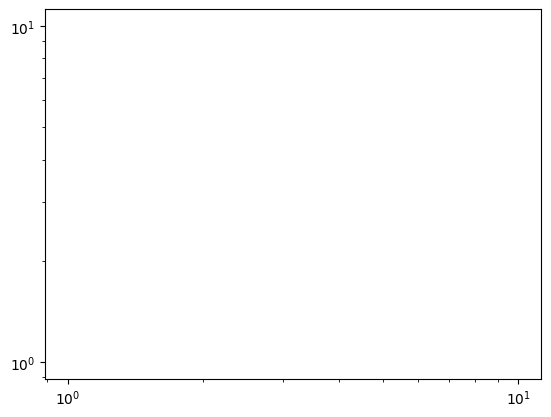